# Simulation result analysis 

- All replicate results are saved separately, check if they share some commonality


## Section I, trajectory analysis

In [2]:
from Config import Config
from usr_func.checkfolder import checkfolder
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20

filepath = "./npy/"
print(os.listdir(filepath))

figpath = os.getcwd() + "/../../../../OneDrive - NTNU/MASCOT_PhD/Projects/GOOGLE/Docs/fig/Sim_2DNidelva/Simulator/"
print(os.listdir(figpath))

c = Config()
plg_b = c.get_polygon_border()
plg_o = c.get_polygon_obstacle()
num_steps = c.get_num_steps()
num_replicates = c.get_num_replicates()

os.system("ls -lh " + filepath)

['R_000', 'R_038', 'R_007', 'R_031', '.DS_Store', 'R_009', 'R_036', 'R_062', 'R_096', 'R_091', 'R_065', 'R_053', 'R_098', 'R_054', 'R_008', 'R_037', 'R_030', 'R_039', 'R_006', 'R_001', 'R_055', 'R_052', 'R_099', 'R_064', 'R_090', 'R_097', 'R_063', 'R_041', 'R_079', 'R_046', 'R_070', 'R_084', 'R_048', 'R_083', 'R_077', 'R_023', 'R_024', 'R_012', 'R_015', 'R_049', 'R_076', 'R_082', 'R_085', 'R_071', 'R_078', 'R_047', 'R_040', 'R_014', 'R_013', 'R_025', 'R_022', 'README.md', 'R_092', 'R_066', 'R_059', 'R_061', 'R_095', 'R_057', 'R_068', 'R_050', 'R_004', 'R_003', 'R_035', 'R_032', 'R_051', 'R_056', 'R_069', 'R_094', 'R_060', 'R_067', 'R_093', 'R_058', 'R_033', 'R_034', 'R_002', 'R_005', 'R_027', 'R_018', 'R_020', 'R_016', 'R_029', 'R_011', 'R_045', 'R_089', 'R_042', 'R_080', 'R_074', 'R_073', 'R_087', 'R_010', 'R_017', 'R_028', 'R_021', 'R_026', 'R_019', 'R_086', 'R_072', 'R_075', 'R_081', 'R_088', 'R_043', 'R_044']
['.DS_Store', 'sigma_01', 'Myopic', 'sigma_10', 'RRT']
total 8
-rw-r--r--

0

In [3]:
Simulators = ["SimulatorRRTStar", "SimulatorMyopic2D"]
sigmas = [1., .1]
nuggets = [.4, .01]

replicates = os.listdir(filepath)
Nrep = 0
for rep in replicates: 
    if rep.startswith("R_"):
        Nrep += 1
print("Number of replicates: ", Nrep)

def plotf(i, title, filename):
    fig = plt.figure(figsize=(40, 24))
    gs = GridSpec(nrows=2, ncols=3)

    def plot_subplot(data, title):
        for j in range(data.shape[0]):
            plt.plot(data[j, :i, 1], data[j, :i, 0], 'k.-', alpha=.4)
            ax.plot(plg_b[:, 1], plg_b[:, 0], 'r-.')
            ax.plot(plg_o[:, 1], plg_o[:, 0], 'r-.')
            ax.set_xlabel("East")
            ax.set_ylabel("North")
            ax.set_title(title)
            ax.set_aspect("equal")
    
    def plotf_sim(data, steps, ylabel="IBV"):
        N = data.shape[0]
        
        hx = np.arange(steps)
        ax.errorbar(hx, y=np.mean(data[:, 0, :steps], axis=0), yerr=np.std(data[:, 0, :steps], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                             label="EIBV dominant")
        ax.errorbar(hx, y=np.mean(data[:, 1, :steps], axis=0), yerr=np.std(data[:, 1, :steps], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                             label="IVR dominant")
        ax.errorbar(hx, y=np.mean(data[:, 2, :steps], axis=0), yerr=np.std(data[:, 2, :steps], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                             label="Equal weights")
        plt.legend(loc="lower left")
        plt.xlabel('Time steps')
        plt.ylabel(ylabel)
        
    ax = fig.add_subplot(gs[0])
    plot_subplot(traj[:, 0, :, :], "EIBV dominant")
    
    ax = fig.add_subplot(gs[1])
    plot_subplot(traj[:, 1, :, :], "IVR dominant")
    
    ax = fig.add_subplot(gs[2])
    plot_subplot(traj[:, 2, :, :], "Equal weights")
    
    ax = fig.add_subplot(gs[3])
    plotf_sim(ibv, i, "IBV")

    ax = fig.add_subplot(gs[4])
    plotf_sim(vr, i, "VR")

    ax = fig.add_subplot(gs[5])
    plotf_sim(rmse, i, "RMSE")

    plt.suptitle(title)
    
    plt.savefig(filename)
    plt.close("all")

    
for sigma in sigmas: 
    for nugget in nuggets: 
        for simulator in Simulators: 
            string = "/sigma_{:02d}/".format(int(10*sigma)) + "nugget_{:03d}/".format(int(100*nugget)) + simulator + "/"
            traj = np.empty([0, 3, num_steps, 2])
            ibv = np.empty([0, 3, num_steps])
            rmse = np.empty([0, 3, num_steps])
            vr = np.empty([0, 3, num_steps])
            
            for i in range(Nrep):
                rep = "R_{:03d}".format(i)
                datapath = filepath + rep + string
                r_traj = np.load(datapath + "traj.npy").reshape(1, 3, num_steps, 2)
                r_ibv = np.load(datapath + "ibv.npy").reshape(1, 3, num_steps)
                r_vr = np.load(datapath + "vr.npy").reshape(1, 3, num_steps)
                r_rmse = np.load(datapath + "rmse.npy").reshape(1, 3, num_steps)
                
                traj = np.append(traj, r_traj, axis=0)
                ibv = np.append(ibv, r_ibv, axis=0)
                vr = np.append(vr, r_vr, axis=0)
                rmse = np.append(rmse, r_rmse, axis=0)
            
            savefig = figpath[:-1] + string
            checkfolder(savefig)
            
            for i in tqdm(range(traj.shape[2])):
                plotf(i, "sigma: {:.1f}, nugget: {:.2f}, simulator: {:s}".format(sigma, nugget, simulator), filename=savefig + "P_{:03d}.png".format(i))

# f1 = filepath + "R_000/sigma_10/nugget_040/SimulatorRRTStar/"
# f2 = filepath + "R_001/sigma_10/nugget_040/SimulatorRRTStar/"

# os.system("ls -lh " + f1)
# os.system("ls -lh " + f2)

# t1 = np.load(f1 + "traj.npy")
# t2 = np.load(f2 + "traj.npy")
# 

Number of replicates:  100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:36<00:00,  1.96s/it]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Simulation result for Myopic path planning

In [28]:
ibv.shape

(3, 3, 5)

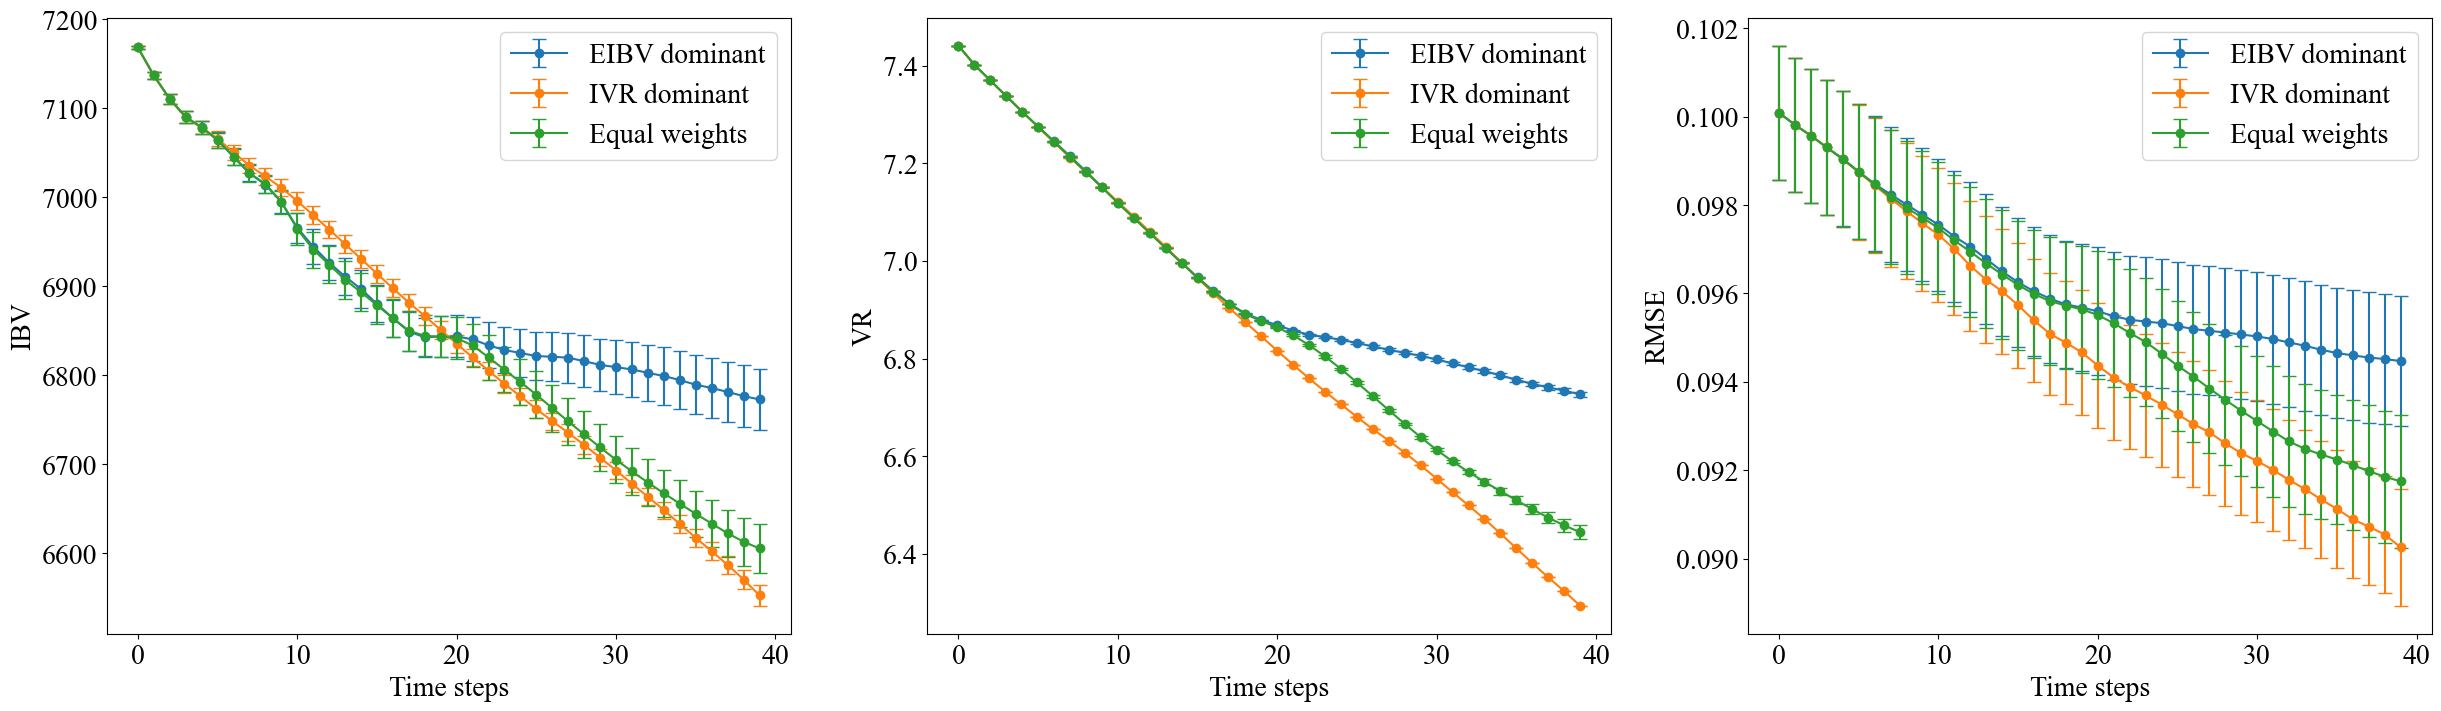

In [67]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)





plt.savefig(figpath + "../../Results/small_grf.png")




In [59]:
os.listdir(figpath + "../../Results/")

['large_grf_coef.png', 'Myopic.png']